# Demo code: Convolutional Neural Network (CNN)
This demo we will demo code for using CNN to solve the classification problem:
-   Problem: Surface defect classification (Binary classification)
-   Dataset: A-Side dataset of our product DCV81
    -   Inspecting A1 Defect type
    -   Train folder:
        -   A1 folder: Sample NG  (17 images) 
        -   Good folder: Sample OK  (30 images)
    -   Validation folder:
        -   A1 folder: Sample NG (6 images) 
        -   Good folder: Sample OK (10 images)
    -   Test folder:
        -   A1 folder: Sample NG (6 images) 
        -   Good folder: Sample OK (10 images)
-   Labeling dataset:
    -   0: OK class
    -   1: NG class
-   Library packages:
    -   Numpy (Numpy arrays are very fast and can perform large computations in a very short time)
    -   PIL (Simple image processing package: read, show, resize,...)
    -   Matplotlib (Plot package: visualize result,....)
    -   TensorFlow (This is an open-source library that is used for DL/ML/AI)
    -   Scikit-Learn (Machine Learning models: KNN,SVM,Decision Tree, Metrics,...)

Tasks Outlines:
## Task 0: Preparing dataset
-   0.1. Define a function get all paths to each image in the dataset and the class label of each image
-   0.2. Define a function to get all image array and its class label (which are in typy np.array)
-   0.3. Getting data by using two previous function
-   0.4. Normalize dataset and reshape dataset to standard form
## Task 1: Constructing model by using TensorFlow library:
-   1.1. Create a convolutional neural network for classification problem
-   1.2. Training model on our trainset and applying the early stopping during the training
## Task 2: Evaluating the trained model on the testset
-   2.1. Predict the class of input images in the testset
-   2.2. Compute the metrics (quantitative measurements) 
    -   For example on Classification task: Accuracy, Precesion, Recall, Confusion Matrix, F1-Score, Cross-Entropy Loss,...
## Task 3: Loading the trained model and Exploring the detail of convolutional layers
-   3.1. Loading the trained model.
-   3.2. Exploring the weight and bias of convolutional layers
*****************************************************************************

## Import all packages

In [1]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time

from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D, Activation
from keras.models import Model

from sklearn import metrics

2024-01-31 09:08:20.166624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Task 0: Preparing Dataset

### 0.1. Define a function get all paths to each image in the dataset and the class label of each image

In [2]:
def get_all_img_label_path(input_dir:str,
                            img_suffix = '.bmp')->(list,list):
    """
    parameters:
    -   input_dir: the directory to the data folder
    -   img_suffix: siffix type of image in the data folder to read
    output: a tuple of two lists:
    -   List of all path to each image in the data folder
    -   List of relative class for each image in the data folder
    """
    label_to_number = {"Good":0,"A1":1}
    list_img_paths = []
    list_labels = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            file_path = os.path.join(root,file)

            file_name,file_suffix = os.path.splitext(file)
            if file_suffix == img_suffix:
                list_img_paths.append(file_path)
                folder_name = os.path.basename(os.path.dirname(file_path))
                list_labels.append(label_to_number[folder_name])
    return (list_img_paths,list_labels)

### 0.2. Define a function to get all image array and its class label (which are in type np.array)
In this function we also resize the all image to the same new size = (width, height)

In [3]:
# Resize the image to small dimensional of width and height
def get_data(list_img_paths:list,
             list_labels:list,
             is_resize:bool= True,
             width:int = 32,
             height:int = 32) -> (np.array,np.array):
    """
    Parameters:
    -   list_img_paths: List of all paths to image in the data folder
    -   list_labels: The list of labels relative to each image in the list_img_paths
    -   is_resize: Default is True means resize all image in the dataset
        to the new size (width,height)
    -   width: The width size which we want to resize to
    -   height: The height size which we want to resize to

    Output: A tuple of two arrays
    -   data_array with shape (N,h,w), where
        -   N is the number of image
        -   h is the height
        -   w is the width
    -   label_array with shape (N,)
    """
    data = []
    for i in range(len(list_img_paths)):
        path_img = list_img_paths[i]
        img = Image.open(path_img).convert('L')
        if is_resize:
            img = img.resize(size = (width,height),
                            resample=Image.BICUBIC)
        data.append(np.array(img))
    return (np.array(data),np.array(list_labels))

### 0.3. Getting data by using two previouse function

In [4]:
# Setting for image shape
width = 64 # <--- width of image:
height = 64 # <--- height of image:
n_channels = 1

In [5]:
# Get the list images path and list labels of train, val, test
data_dir = "/Users/user/Victor2023/Dataset/Data_CNN" # Replace this directory by the directory to data in your computer
train_dir = os.path.join(data_dir,"Train")
val_dir = os.path.join(data_dir,"Val")
test_dir = os.path.join(data_dir,"Test")

list_imgs_train,list_labels_train = get_all_img_label_path(input_dir=train_dir,
                                                    img_suffix='.bmp')
list_imgs_val,list_labels_val = get_all_img_label_path(input_dir=val_dir,
                                                    img_suffix='.bmp')
list_imgs_test,list_labels_test = get_all_img_label_path(input_dir=test_dir,
                                                    img_suffix='.bmp')

In [6]:
X_train,label_train = get_data(list_img_paths=list_imgs_train,
               list_labels=list_labels_train,
               is_resize=True,
               width=width,
               height= height)

X_val,label_val = get_data(list_img_paths=list_imgs_val,
               list_labels=list_labels_val,
               is_resize=True,
               width=width,
               height= height)

X_test,label_test = get_data(list_img_paths=list_imgs_test,
               list_labels=list_labels_test,
               is_resize=True,
               width=width,
               height= height)

In [7]:
print(X_train.shape)

(47, 64, 64)


### 0.4. Normalize dataset and reshape dataset to standard form

#### Warning !!

The shape of data image input for CNN model should be (N_samples,height, width, n_channels). In which:
-   N_samples: The total number of samples we have (number of images)
-   height: the height of image
-   width: the width of image
-   n_channels: number of channels in image (our case is gray scale image => n_channels = 1)

Back to our data:
-   Data is image in grayscale we resize to same size (height,width), here is 64 x 64 pixels. The number of channels in image is 1 
-   We have to reshape our data from (N_samples,height,width) to (N_samples,height,width,n_channels)

In [8]:
n_samples_train = X_train.shape[0]
X_train = X_train.reshape((n_samples_train,height,width,n_channels))
# Scaling feature from range [0,255] to range [0,1]
X_train = X_train/255.0
# Convert integers to dummy variables (i.e. one hot encoded)
# Formating the truth label in form of output of model
# y now is the truth output which model must learn to predict
y_train = to_categorical(label_train)

In [9]:
n_samples_val = X_val.shape[0]
X_val = X_val.reshape((n_samples_val,height,width,n_channels))
X_val = X_val/255.0
y_val = to_categorical(label_val)

In [10]:
n_samples_test = X_test.shape[0]
X_test = X_test.reshape((n_samples_test,height,width,n_channels))
X_test = X_test/255.0
y_test = to_categorical(label_test)

In [11]:
print("The currently shape of input dataset X is:", X_train.shape)
print("The currently shape of dummy y is:", y_train.shape)

The currently shape of input dataset X is: (47, 64, 64, 1)
The currently shape of dummy y is: (47, 2)


In [12]:
print("Number of samples in the train subset:", len(y_train))
print("Number of samples in the train subset:", len(y_val))
print("Number of samples in the test subset:", len(y_test))

Number of samples in the train subset: 47
Number of samples in the train subset: 16
Number of samples in the test subset: 16


Show the images of the train set:


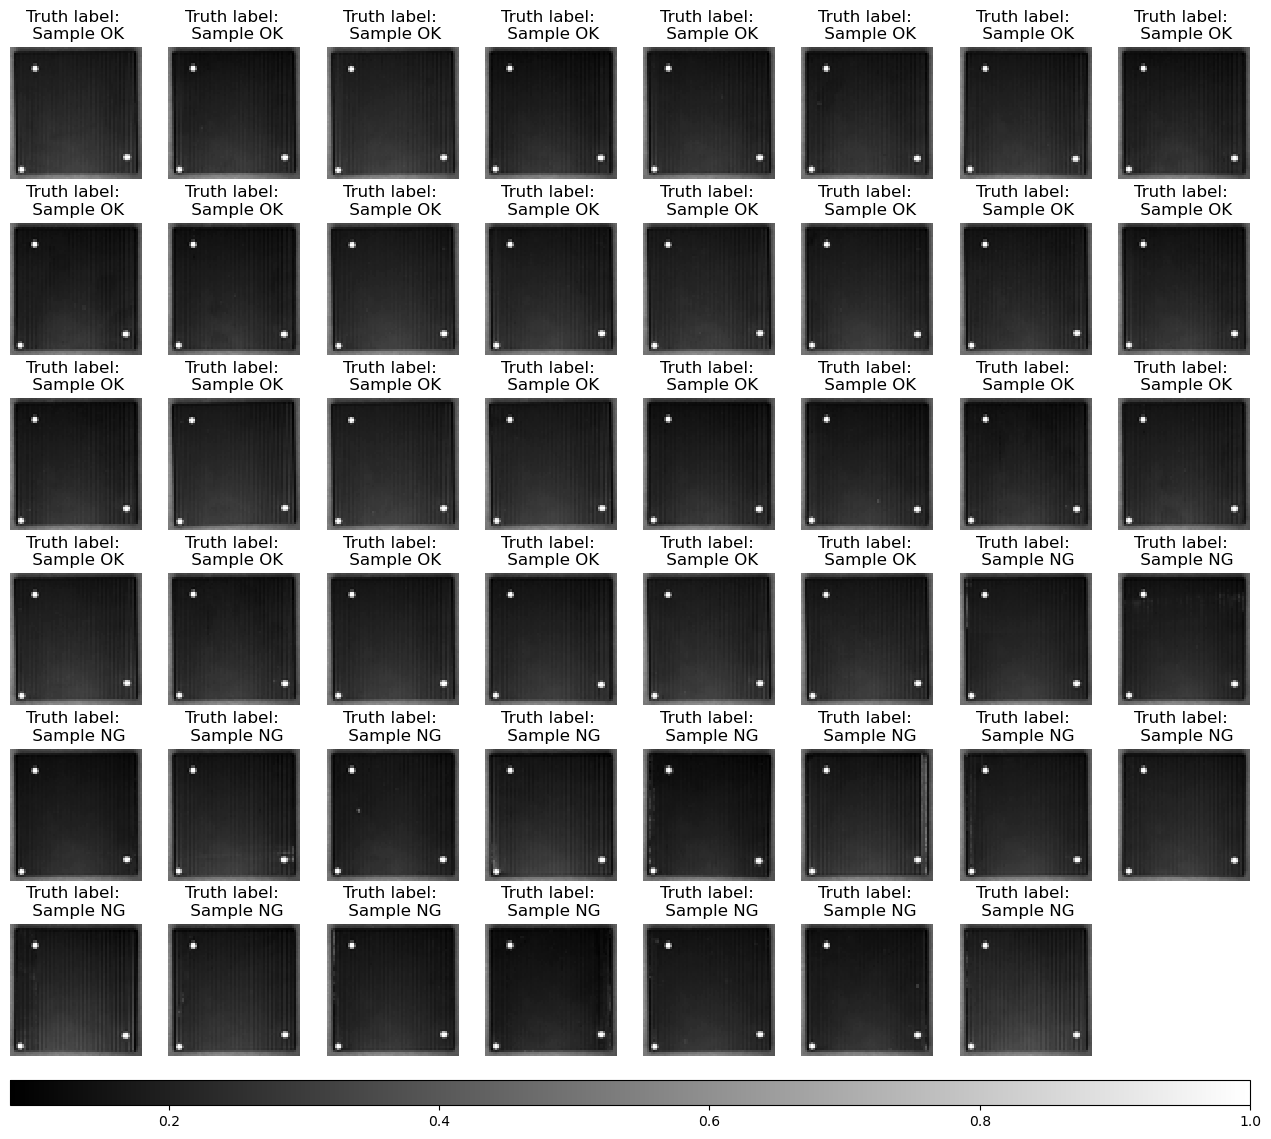

In [13]:
print("Show the images of the train set:")
class_to_label = {0: "Sample OK", 1: "Sample NG"}
truth_train = np.argmax(y_train,axis=-1)
fig,axes = plt.subplots(nrows = 6,ncols = 8, figsize= (16,16))
for r in range(6):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        image = X_train[index].reshape((width,height))
        true_label = truth_train[index]
        photo = axes[r,c].imshow(image, cmap = 'gray', interpolation = "nearest")
        axes[r,c].set_title(f"Truth label: \n {class_to_label[true_label]}")
        # cbar = fig.colorbar(photo)
        if index == 46:
            axes[5,7].set_axis_off()
            break
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)

Show the images of the validation set:


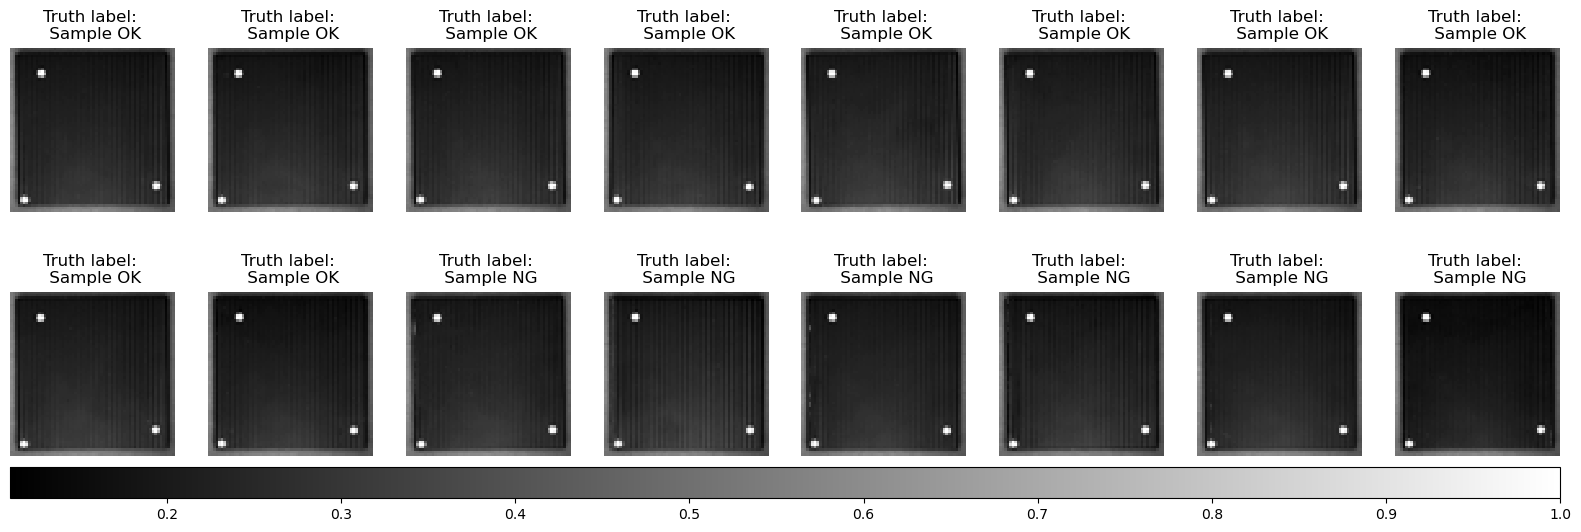

In [15]:
print("Show the images of the validation set:")
class_to_label = {0: "Sample OK", 1: "Sample NG"}
truth_train = np.argmax(y_train,axis=-1)
fig,axes = plt.subplots(nrows = 2,ncols = 8, figsize= (20,7))
for r in range(2):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        image = X_val[index].reshape((width,height))
        true_label = label_val[index]
        photo = axes[r,c].imshow(image, cmap = 'gray', interpolation = "nearest")
        axes[r,c].set_title(f"Truth label: \n {class_to_label[true_label]}")
        # cbar = fig.colorbar(photo)
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)

Show the images of the test set:


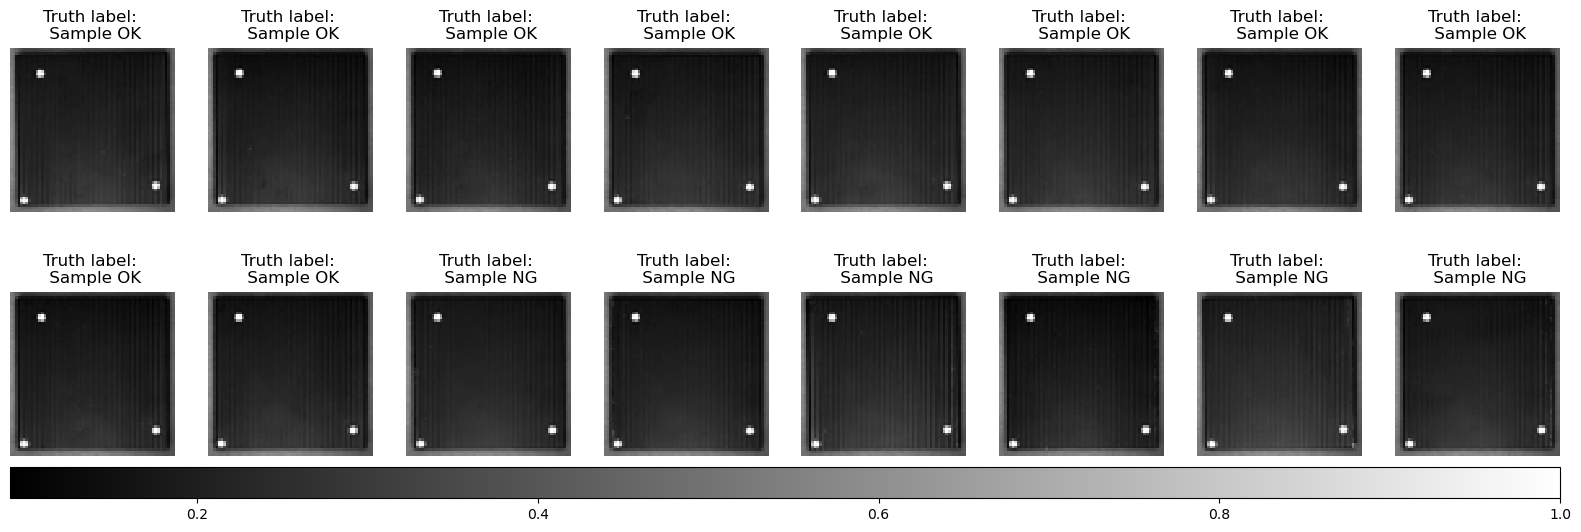

In [16]:
print("Show the images of the test set:")
class_to_label = {0: "Sample OK", 1: "Sample NG"}
truth_train = np.argmax(y_train,axis=-1)
fig,axes = plt.subplots(nrows = 2,ncols = 8, figsize= (20,7))
for r in range(2):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        image = X_test[index].reshape((width,height))
        true_label = label_test[index]
        photo = axes[r,c].imshow(image, cmap = 'gray', interpolation = "nearest")
        axes[r,c].set_title(f"Truth label: \n {class_to_label[true_label]}")
        # cbar = fig.colorbar(photo)
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)

## Task 1: Constructing model by using TensorFlow library:

### 1.1. Creating Convolutional Neural Network model
#### Contruct CNN with 2 Convolution Layers and 2 Fully Connected Layers.

The model CNN takes an input tensors of shape (height,width,n_channels). Here, we configure the CNN to process inputs of shape (64,64,1). So, we passing the argument input_shape = (64,64,1) to the first layer.

-   The 1st Conv2D layer is convolutional operation. 
    -   Conv2D operation: kernel size = (5,5), stride = (1,1).
    -   Activation function: ReLU
    -   Max Pooling2D: window_size = (2,2)
    -   Dropout: p = 0.2 (will randomly disable 20% of the neurons)
-   The 2nd Conv2D layer is convolutional operation.
    -   Conv2D operation: kernel size = (3,3), stride = (1,1).
    -   Activation function: ReLU
    -   Max Pooling2D: pool_size = (2,2)
    -   Dropout: p = 0.2 (will randomly disable 20% of the neurons)
-   The next step is for Fully-Connected layers:
    -   Flattening the 3D outputs of previous layer to 1D by Flatten layer
    -   Adding Dense layer (Linear mapping)
-   In the last Dense layer, we use softmax as activation. It enables our to calculate the output based on the probabilities. Each class is assigned a probability. For final predict we apply the argmax to find the class with the maximum probability.

#### Compute the number of parameters in the model CNN

In [61]:
#### Construct CNN with 2 Convolution Layers and 2 Fully Connected Layers.
# define the input_shape
input_shape = (height,width,n_channels)
# Define the model CNN
model_cnn = Sequential()
## Convolution layer1 : Conv2d => Activation ReLu => MaxPool2D => Dropout
model_cnn.add(Conv2D(filters = 32, # <--- filers: the number of feature maps in Convolutional layer 1
                    kernel_size=(5,5), # <--- kernel_size: the size of 2d feature maps (size of 2d filter or 2d kernel)
                    strides=(1,1), # <--- strides: the number of pixels by which we move the filter across the input image
                    input_shape = input_shape))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.2))


In [62]:

## Convolution layer2 : Conv2d => Activation ReLu => MaxPool2D => Dropout
model_cnn.add(Conv2D(filters = 16, # <--- filers: the number of feature maps in Convolutional layer 2
                    kernel_size=(3,3), # <--- kernel_size: the size of 2d feature maps (size of 2d filter or 2d kernel)
                    strides=(1,1), # <--- strides: the number of pixels by which we move the filter across the input image
                    input_shape = input_shape))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.2))


In [63]:
## Fully-Connected layers:
model_cnn.add(Flatten())
model_cnn.add(Dense(128,activation='relu'))
model_cnn.add(Dense(2)) # <---- The total number of classes: in our case is binary (2 classes)
model_cnn.add(Activation('softmax'))

In [64]:
# Show the model summary
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        832       
                                                                 
 activation_2 (Activation)   (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 activation_3 (Activation)   (None, 28, 28, 16)        0         
                                                      

#### Compute the number parameters in our model:

Layer convolutional 1: 
-   input shape: (64,64,1)
    -   n_channels: 1 
-   output shape: (60,60,32) => 
    -   32 filters (32 kernals) each of size 5x5,
    -   32 biases 
-   The total parameters is: $32*5*5*1 + 32 = 832$

Layer convolutional 2: 
-   input shape: (30,30,32)
    -   n_channels: 32
-   output shape: (28,28,16)
    -   16 filters (16 kernals) each of size 3x3,
    -   16 biases 
-   The total parameters is: $16*3*3*32 + 16 = 4624$

Layer Dense 1: 
-   input shape: 14*14*16 = 3136
-   output shape: 128 => bias shape: 128
-   weight shape: (3136,128)
-   The total parameters is: $3136*128+128 = 401536$

Layer Dense 2 (final output layer): 
-   input shape: 128
-   output shape: 2 => bias shape: 2
-   weight shape: (128,2)
-   The total parameters is: $128*2 + 2 = 258$

### 1.2. Training with functions： EarlyStopping(), ModelCheckpoint(), and ReduceLROnPlateau()

In [65]:
# Define EarlyStopping, ModelCheckpoint, ReduceLearningRateOnPlateau.
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=30)
mc = ModelCheckpoint('best_model_cnn_DCV81_64_5_1.h5',
                     monitor='val_accuracy',
                     mode='max',
                     verbose=1,
                     save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=30,
                              min_lr=0.0001,
                              mode = 'min')

In [66]:
# Training model for 500 epochs
start_time = time.time()
epochs = 500
optimizer = keras.optimizers.Adam()
loss = keras.losses.categorical_crossentropy
q_metrics = ['accuracy']
model_cnn.compile(optimizer = optimizer,
                   loss = loss,
                   metrics = q_metrics)
history = model_cnn.fit(X_train,y_train,
                         batch_size = 32,
                         epochs = epochs,
                         validation_data = (X_val,y_val),
                         verbose = 2,
                         callbacks = [es,mc,reduce_lr])
end_time = time.time()
training_time = end_time - start_time


Epoch 1/500



Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to best_model_cnn_DCV81_64_5_1.h5
2/2 - 1s - loss: 0.6977 - accuracy: 0.5319 - val_loss: 0.6574 - val_accuracy: 0.6250 - lr: 0.0010 - 1s/epoch - 562ms/step
Epoch 2/500

Epoch 2: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 0.6540 - accuracy: 0.6383 - val_loss: 0.6681 - val_accuracy: 0.6250 - lr: 0.0010 - 211ms/epoch - 105ms/step
Epoch 3/500

Epoch 3: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 0.6531 - accuracy: 0.6383 - val_loss: 0.6642 - val_accuracy: 0.6250 - lr: 0.0010 - 195ms/epoch - 97ms/step
Epoch 4/500

Epoch 4: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 0.6579 - accuracy: 0.6383 - val_loss: 0.6605 - val_accuracy: 0.6250 - lr: 0.0010 - 247ms/epoch - 123ms/step
Epoch 5/500

Epoch 5: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 0.6508 - accuracy: 0.6383 - val_loss: 0.6616 - val_accuracy: 0.6250 - lr: 0.0010 - 186ms/epoch - 93ms/step
Epoch 6/500

Epoch 6: v

In [67]:
# Show the total time for training
print(f"The total time for training model with {len(history.history['accuracy'])} is: {training_time} second")

The total time for training model with 296 is: 74.99858593940735 second


Plot the training history:


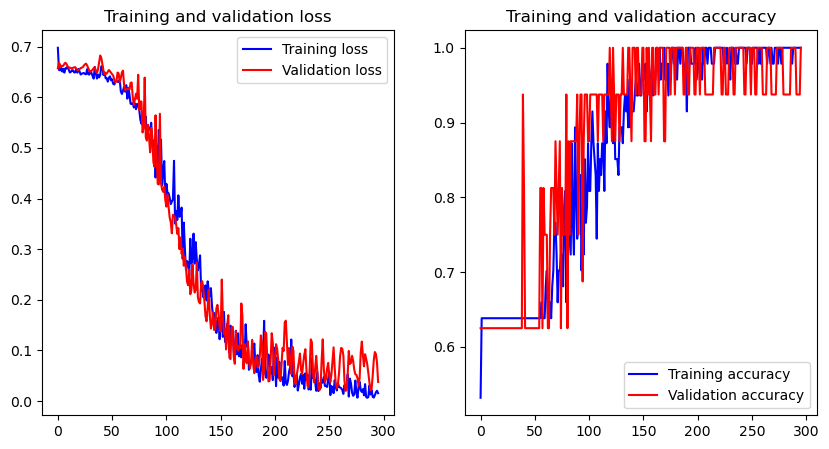

In [68]:
# Plot the training history
print("Plot the training history:")
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

fig,axes = plt.subplots(nrows = 1,ncols = 2, figsize= (10,5))
axes[0].plot(epochs, loss, 'b', label='Training loss')
axes[0].plot(epochs, val_loss, 'r', label='Validation loss')
axes[0].set_title('Training and validation loss')
axes[0].legend()

axes[1].plot(epochs, accuracy, 'b', label='Training accuracy')
axes[1].plot(epochs, val_accuracy, 'r', label='Validation accuracy')
axes[1].set_title('Training and validation accuracy')
axes[1].legend()


## Task 2: Evaluating the trained model on the testset

### 2.1. Predict the class of input images in the testset

In [69]:
output_test = model_cnn.predict(X_test)

1/1 [==============================] - 0s 115ms/step


In [70]:
pred_test = np.argmax(output_test,axis=-1)
truth_test = np.argmax(y_test,axis=-1)

Show the result on the test set:


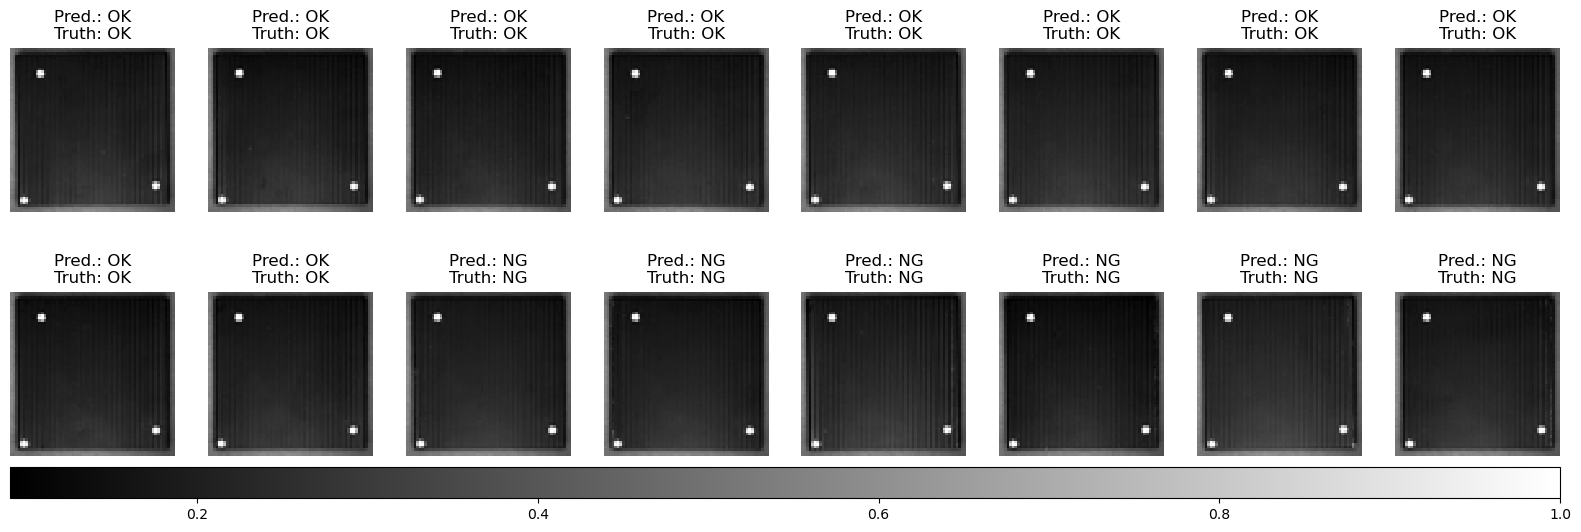

In [71]:
# Visualize the test samples and show their predicted digit value in the title.
print("Show the result on the test set:")
class_to_label = {0: "OK", 1: "NG"}
fig,axes = plt.subplots(nrows = 2,ncols = 8, figsize= (20,7))
for r in range(2):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        image = X_test[index].reshape((width,height))
        pred_label = pred_test[index]
        true_label = truth_test[index]
        photo = axes[r,c].imshow(image, cmap = 'gray', interpolation = "nearest")
        if pred_label == true_label:
            axes[r,c].set_title(f"Pred.: {class_to_label[pred_label]}\nTruth: {class_to_label[true_label]}")
        else:
            axes[r,c].set_title(f"Pred.: {class_to_label[pred_label]}\nTruth: {class_to_label[true_label]}",color = 'red')
        # cbar = fig.colorbar(photo)
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)


### 2.2. Compute the metrics (quantitative measurements)

Text(0.5, 0.98, 'Number occurrences of each class on test set')

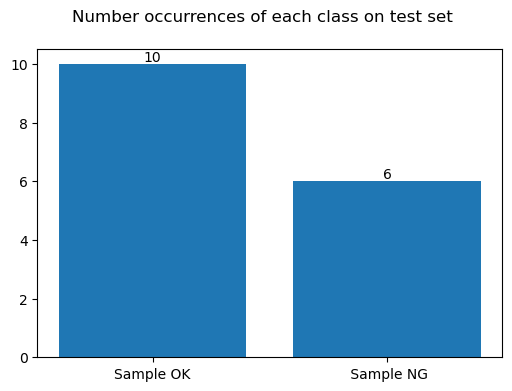

In [72]:
nb_classes = len(np.unique(truth_test))
## Visual bar plot of number occurrences of each class in testset:
class_to_label = {0: "Sample OK", 1: " Sample NG"}
statistic_class = np.unique(truth_test,return_counts=True)
categoricalClasses = [f'{class_to_label[C]}' for C in statistic_class[0]]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.bar(x = categoricalClasses, height = statistic_class[1],width = 0.8)
for i in range(nb_classes):
    ax.text(categoricalClasses[i],statistic_class[1][i],
            str(statistic_class[1][i]),ha='center',va = 'bottom')
fig.suptitle("Number occurrences of each class on test set")

In [73]:
# Classification report:
print(f"Classification report for classifier {model_cnn}:\n"
      f"{metrics.classification_report(truth_test,pred_test,digits=4)}\n")

Classification report for classifier <keras.engine.sequential.Sequential object at 0x1408e71f0>:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        10
           1     1.0000    1.0000    1.0000         6

    accuracy                         1.0000        16
   macro avg     1.0000    1.0000    1.0000        16
weighted avg     1.0000    1.0000    1.0000        16




Confusion matrix:
[[10  0]
 [ 0  6]]


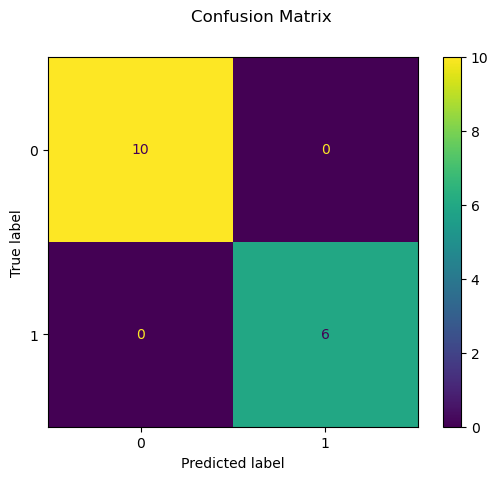

In [74]:
# Confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(truth_test,pred_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

## 3. Task 3: Loading the trained model

### 3.1. Loading the trained model
We have named the best model during the training process as "best_model_cnn_DCV81.h5"

In [75]:
# !!!!! Replace the directory below by the directory to the best_model in your computer!
trained_model_dir = "/Users/user/AI_Class/P4_DeepLearning/S2_ConvolutionalNN/best_model_cnn_DCV81_64_5_1.h5" # <--- Change this directory
load_model = keras.models.load_model(trained_model_dir)

In [76]:
# Show the layer name of all layer in load_model:
print("List of all layer in the loaded model:")
index = 0
for layer in load_model.layers:
    print(f"index {index}: ",layer.name)
    index += 1

List of all layer in the loaded model:
index 0:  conv2d_2
index 1:  activation_2
index 2:  max_pooling2d_2
index 3:  dropout_2
index 4:  conv2d_3
index 5:  activation_3
index 6:  max_pooling2d_3
index 7:  dropout_3
index 8:  flatten_1
index 9:  dense_2
index 10:  dense_3
index 11:  activation_4


### 3.2. Exploring the detail of convolutional layers

In this part we will plot the feature maps of the following input image:


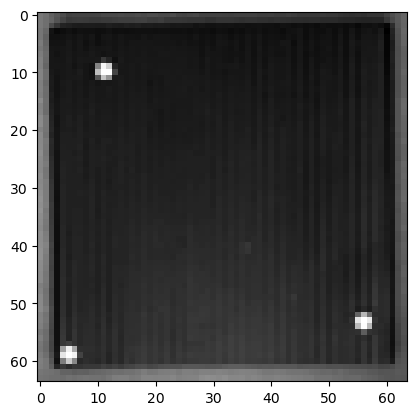

In [77]:
print("In this part we will plot the feature maps of the following input image:")
img_test_index = 0
image = X_test[img_test_index].reshape((width,height))
plt.imshow(image, cmap = 'gray', interpolation = "nearest")


#### 3.2.1 Getting the weights and biases of the convolutional layers

In [78]:
# Getting the weights and biases of the first layer in the load_model
index = 0
weights, biases = load_model.layers[index].get_weights()
print("The shape of weights and biases of the first conv2d:")
print("Weights shape:", weights.shape)
print("Biases shape:", biases.shape)

The shape of weights and biases of the first conv2d:
Weights shape: (5, 5, 1, 32)
Biases shape: (32,)


In [79]:
# Getting the weights and biases of the first layer in the load_model
index = 4
weights_1, biases_1 = load_model.layers[index].get_weights()
print("The shape of weights and biases of the second conv2d:")
print("Weights shape:", weights_1.shape)
print("Biases shape:", biases_1.shape)

The shape of weights and biases of the second conv2d:
Weights shape: (3, 3, 32, 16)
Biases shape: (16,)


In [80]:
# Getting the output each layer in the trained model
list_layer = []
for i in range(len(load_model.layers)):
    list_layer.append(Model(inputs=load_model.inputs, outputs=load_model.layers[i].output))

#### 3.2.2. Plotting the convolutional map： kernel (filter), feature map

Show the 32 convolutional maps of the first Conv:


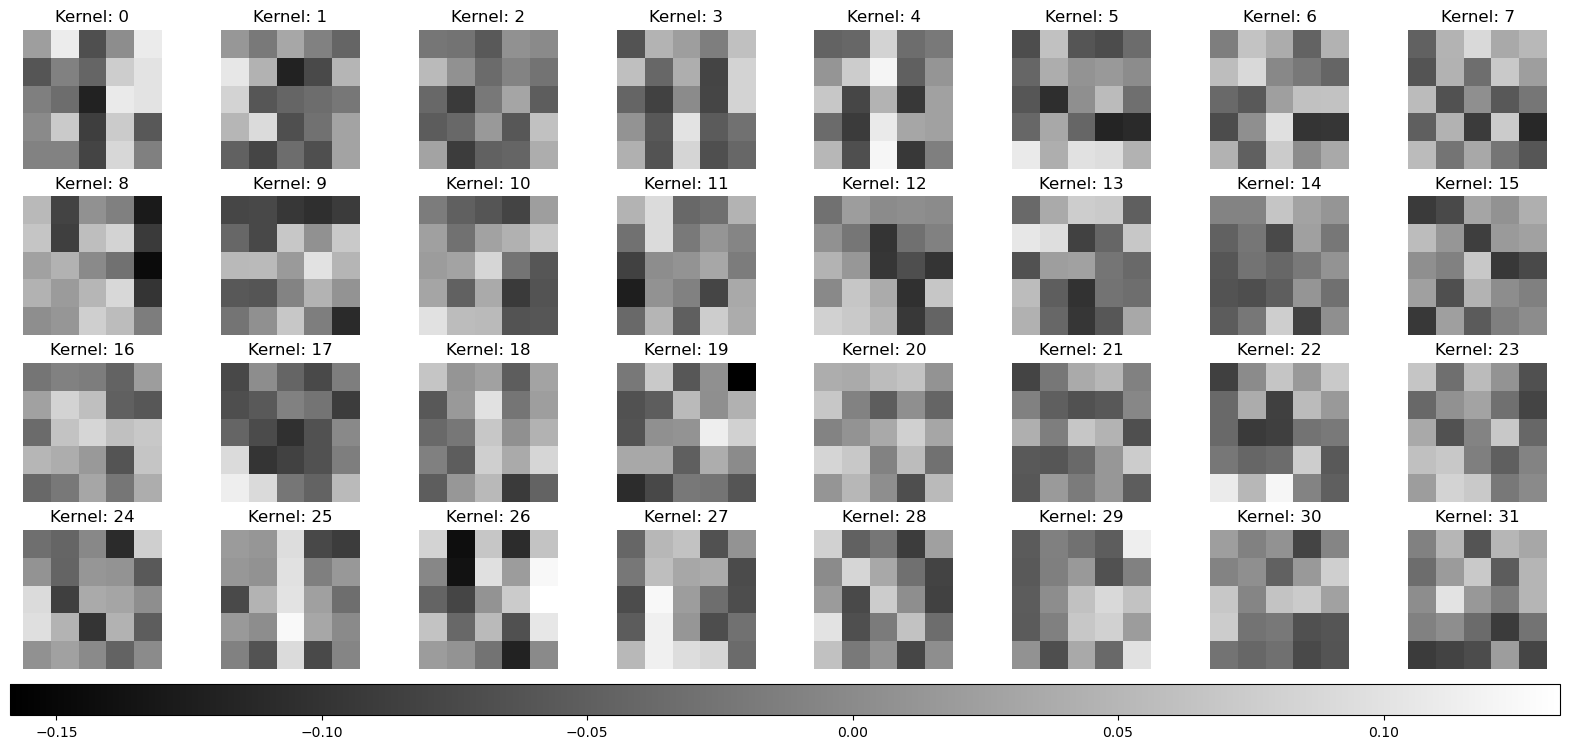

In [81]:
# Visualize the 32 convolutional maps (filters or kernels)
print("Show the 32 convolutional maps of the first Conv:")
w0_min = weights.min()
w0_max = weights.max()
fig,axes = plt.subplots(nrows = 4,ncols = 8, figsize= (20,10))
for r in range(4):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        photo = axes[r,c].imshow(weights[:,:,0,index], cmap = 'gray',vmin = w0_min,vmax = w0_max, interpolation = "nearest")
        axes[r,c].set_title(f"Kernel: {index}")
        # cbar = fig.colorbar(photo)
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)

In [82]:
# Show the value of kernel 0
weights[:,:,0,0]

array([[ 0.02179774,  0.11098567, -0.06809539,  0.00309293,  0.11026249],
       [-0.06105153, -0.01157437, -0.04282963,  0.0757571 ,  0.10113318],
       [-0.01282775, -0.03345116, -0.1195002 ,  0.10875033,  0.1004917 ],
       [-0.00050278,  0.07173331, -0.08694497,  0.07287964, -0.05769796],
       [-0.01013837, -0.00996402, -0.08011257,  0.08652718, -0.01229113]],
      dtype=float32)

### 3.3. Plotting the feature maps (results after the convolutional operation)

In [83]:
# Compute the feature maps of the input image under each layers
list_feature_results = []
for i in range(len(list_layer)):
    feature_result = list_layer[i].predict(X_test[:1,:,:,:])
    list_feature_results.append(feature_result)

1/1 [==============================] - 0s 77ms/step


Visualize the 32 feature maps under the 1st layer conv2d:


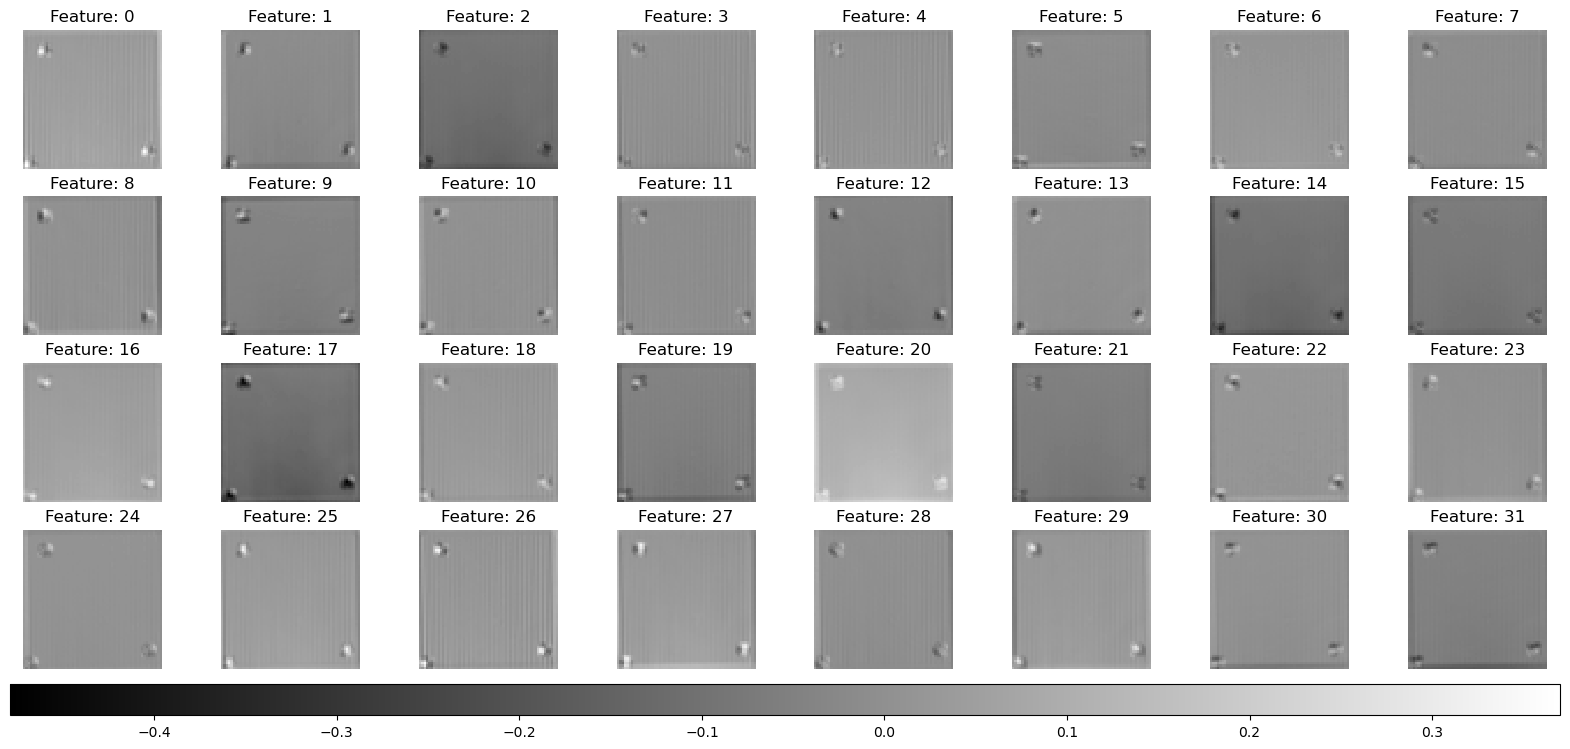

In [84]:
# Visualize the 32 feature maps under the first conv2d 
print("Visualize the 32 feature maps under the 1st layer conv2d:")
i_layer = 0

f_max = list_feature_results[i_layer].max()
f_min = list_feature_results[i_layer].min()
fig,axes = plt.subplots(nrows = 4,ncols = 8, figsize= (20,10))
for r in range(4):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        photo = axes[r,c].imshow(list_feature_results[i_layer][0,:,:,index], cmap = 'gray',vmin = f_min,vmax = f_max, interpolation = "nearest")
        axes[r,c].set_title(f"Feature: {index}")
        # cbar = fig.colorbar(photo)
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)


Visualize the 32 feature maps after the 1st layer conv2d and activation:


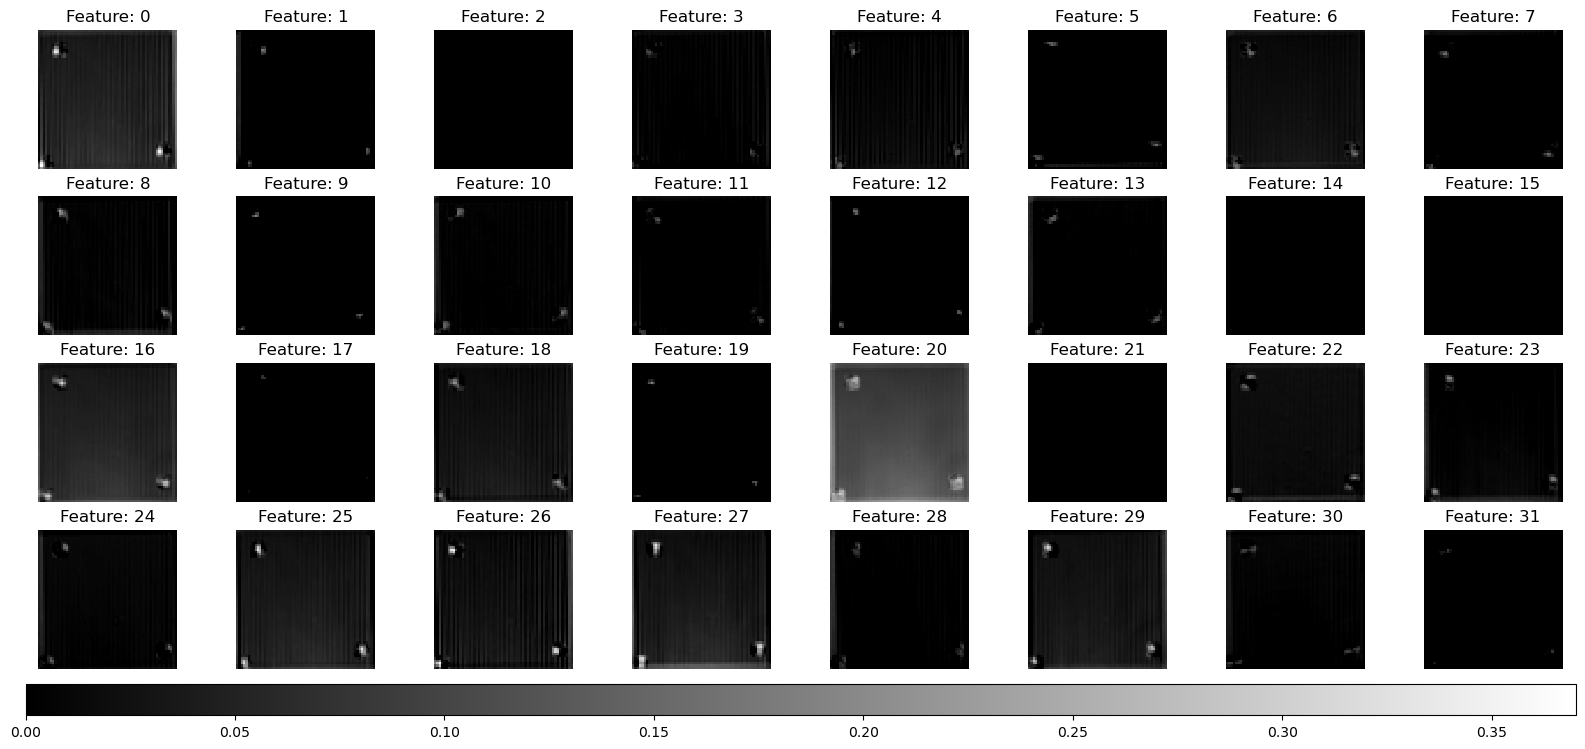

In [85]:
# Visualize the 32 feature maps after the 1st layer conv2d and activation
print("Visualize the 32 feature maps after the 1st layer conv2d and activation:")
i_layer = 1

f_max = list_feature_results[i_layer].max()
f_min = list_feature_results[i_layer].min()
_,axes = plt.subplots(nrows = 4,ncols = 8, figsize= (20,10))
for r in range(4):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        photo = axes[r,c].imshow(list_feature_results[i_layer][0,:,:,index], cmap = 'gray',vmin = f_min,vmax = f_max, interpolation = "nearest")
        axes[r,c].set_title(f"Feature: {index}")
        # cbar = fig.colorbar(photo)
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)

Visualize the 32 feature maps  after after the 1st layer conv2d, activation and pooling:


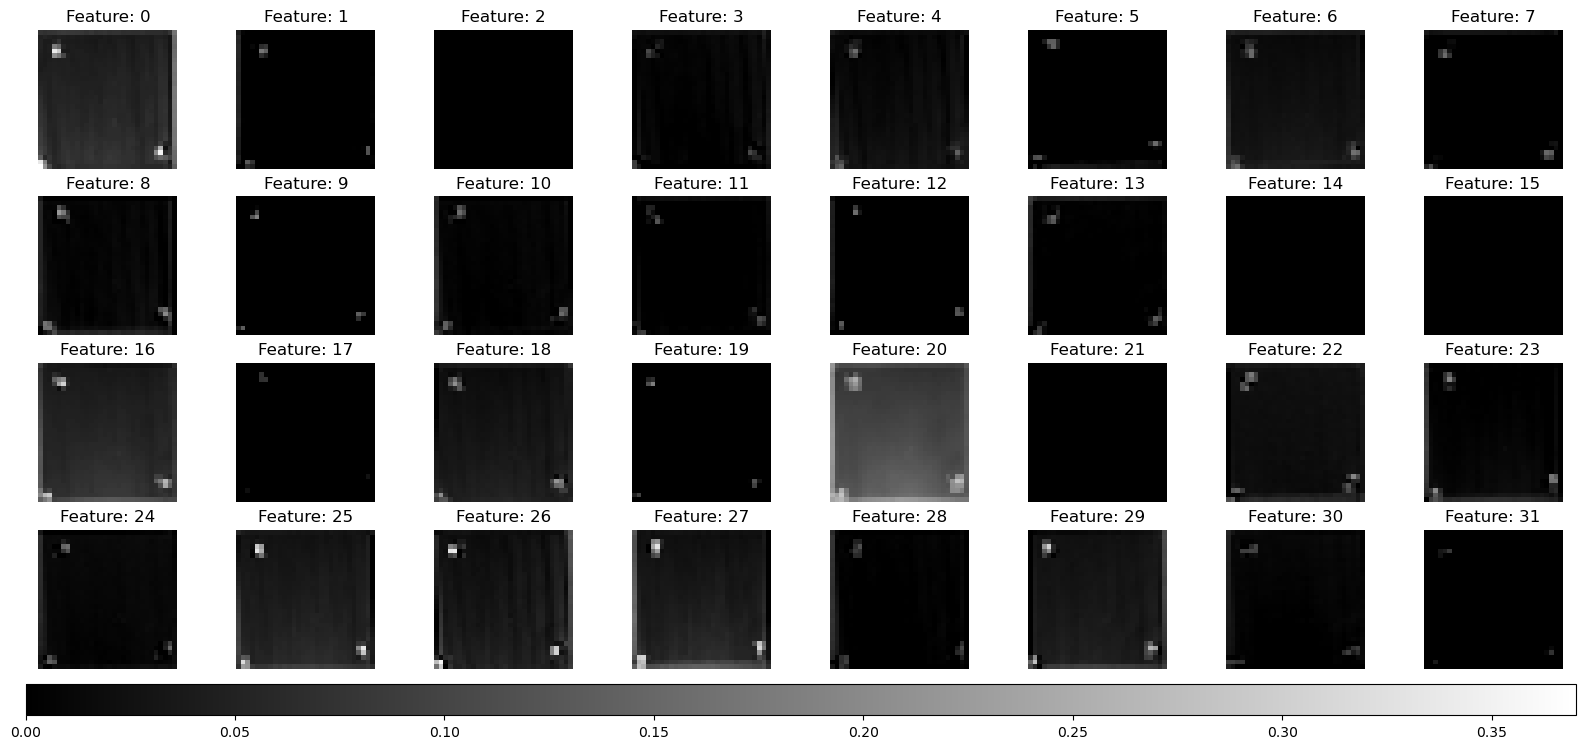

In [86]:
# Visualize the 32 feature maps after the 1st layer conv2d, activation and pooling
print("Visualize the 32 feature maps  after after the 1st layer conv2d, activation and pooling:")
i_layer = 2

f_max = list_feature_results[i_layer].max()
f_min = list_feature_results[i_layer].min()
_,axes = plt.subplots(nrows = 4,ncols = 8, figsize= (20,10))
for r in range(4):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        photo = axes[r,c].imshow(list_feature_results[i_layer][0,:,:,index], cmap = 'gray',vmin= f_min, vmax=f_max, interpolation = "nearest")
        axes[r,c].set_title(f"Feature: {index}")
        # cbar = fig.colorbar(photo)
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)

Visualize the 16 feature maps under the 2nd layer conv2d:


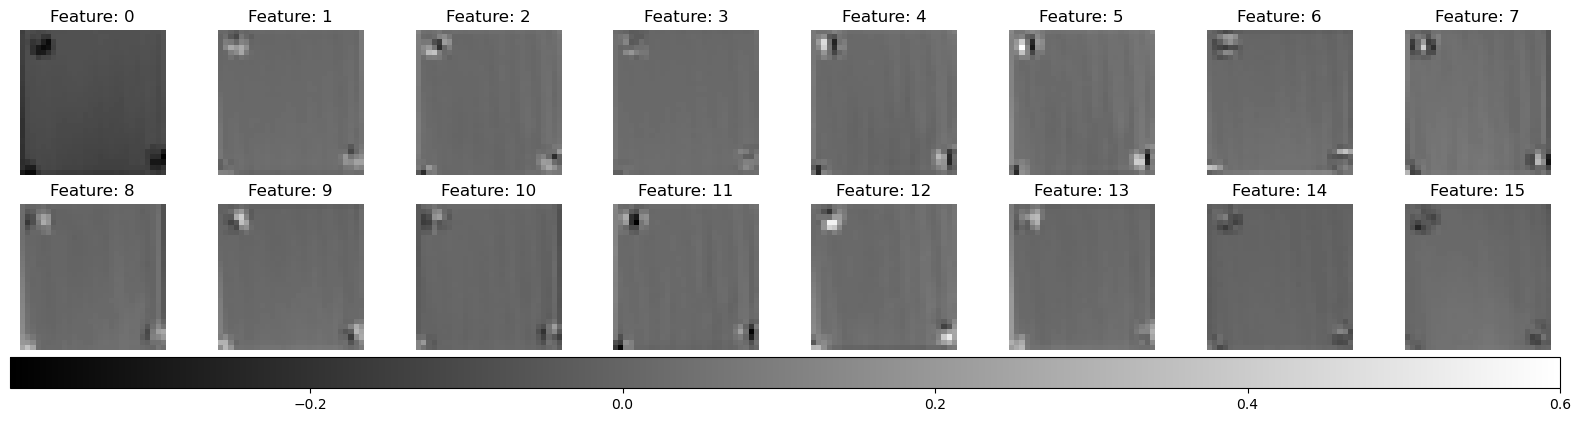

In [87]:
# Visualize the 16 feature maps after the 2nd layer conv2d
print("Visualize the 16 feature maps under the 2nd layer conv2d:")
i_layer = 4

f_max = list_feature_results[i_layer].max()
f_min = list_feature_results[i_layer].min()
fig,axes = plt.subplots(nrows = 2,ncols = 8, figsize= (20,5))
for r in range(2):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        photo = axes[r,c].imshow(list_feature_results[i_layer][0,:,:,index], cmap = 'gray',vmin = f_min,vmax = f_max, interpolation = "nearest")
        axes[r,c].set_title(f"Feature: {index}")
        # cbar = fig.colorbar(photo)
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)

Visualize the 16 feature maps under the 2nd layer conv2d, activation:


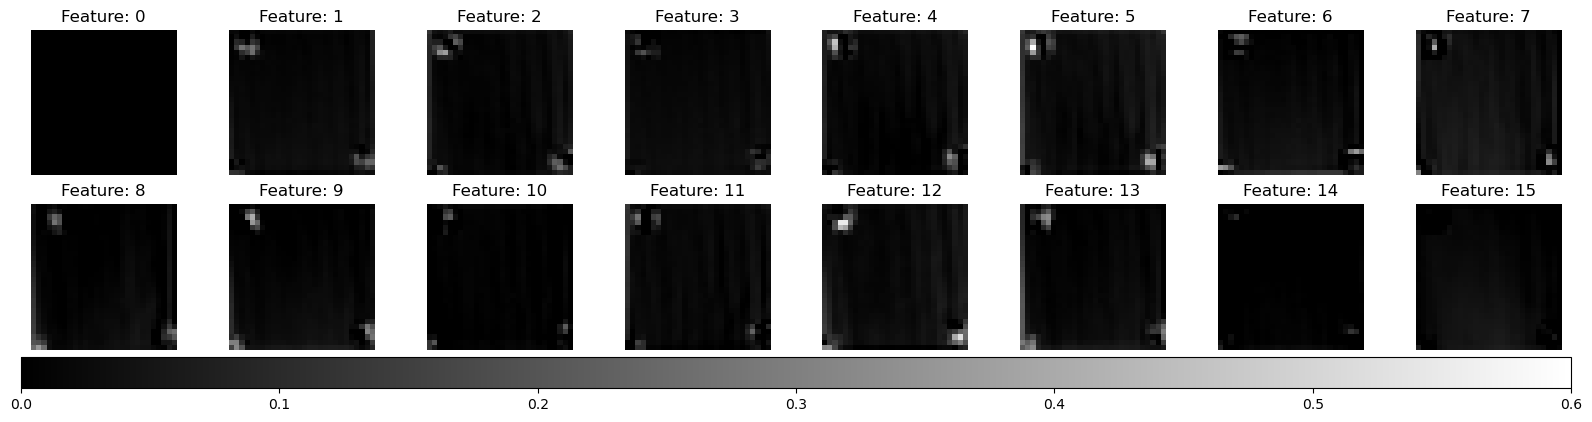

In [88]:
# Visualize the 16 feature maps after the 2nd conv2d, activation
print("Visualize the 16 feature maps under the 2nd layer conv2d, activation:")
i_layer = 5

f_max = list_feature_results[i_layer].max()
f_min = list_feature_results[i_layer].min()
fig,axes = plt.subplots(nrows = 2,ncols = 8, figsize= (20,5))
for r in range(2):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        photo = axes[r,c].imshow(list_feature_results[i_layer][0,:,:,index], cmap = 'gray',vmin = f_min,vmax = f_max, interpolation = "nearest")
        axes[r,c].set_title(f"Feature: {index}")
        # cbar = fig.colorbar(photo)
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)

Visualize the 16 feature maps under the 2nd layer conv2d, activation and pooling:


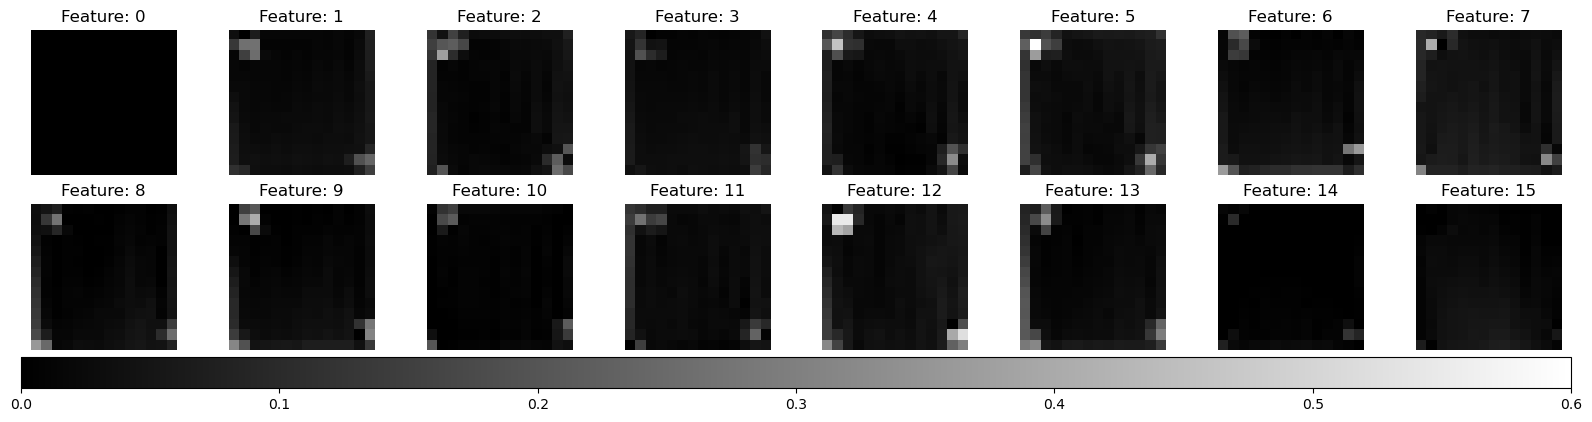

In [89]:
# Visualize the 16 feature maps after the 2nd conv2d, activation and pooling
print("Visualize the 16 feature maps under the 2nd layer conv2d, activation and pooling:")
i_layer = 6

f_max = list_feature_results[i_layer].max()
f_min = list_feature_results[i_layer].min()
fig,axes = plt.subplots(nrows = 2,ncols = 8, figsize= (20,5))
for r in range(2):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        photo = axes[r,c].imshow(list_feature_results[i_layer][0,:,:,index], cmap = 'gray',vmin = f_min,vmax = f_max, interpolation = "nearest")
        axes[r,c].set_title(f"Feature: {index}")
        # cbar = fig.colorbar(photo)
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)

Visualize the feature maps under the output layer flatten:
The size of feature is: (1, 3136)
The value of feature is:


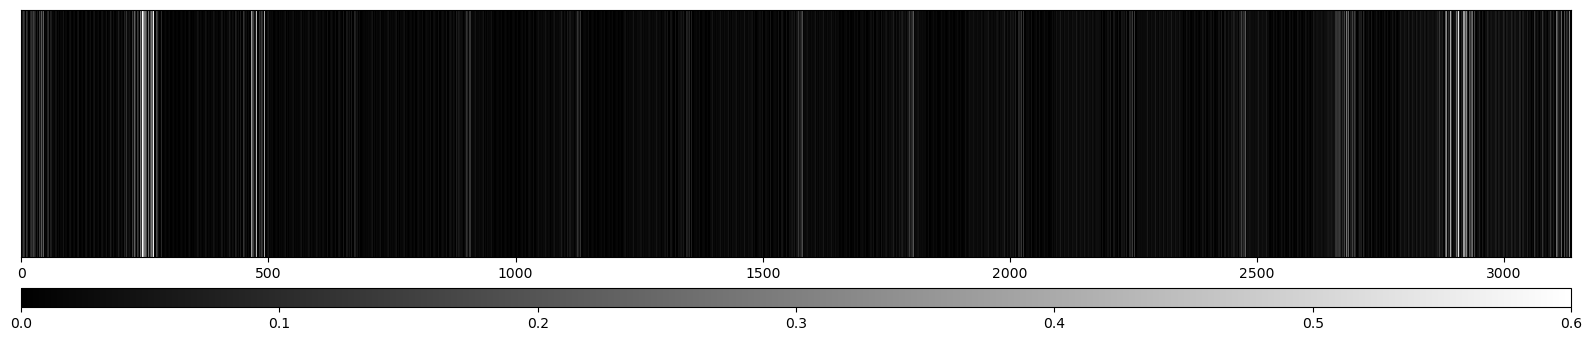

In [90]:
# Visualize the feature maps after the flatten
print("Visualize the feature maps under the output layer flatten:")
i_layer = 8
f_max = list_feature_results[i_layer].max()
f_min = list_feature_results[i_layer].min()

print("The size of feature is:", list_feature_results[i_layer].shape)
print("The value of feature is:")
img_flatten = np.array([list_feature_results[i_layer][0] for i in range(500)])




fig,axes = plt.subplots(nrows = 1,ncols = 1, figsize= (20,20))
axes.get_yaxis().set_visible(False)
# axes.set_title(f"Flatten feature:")
photo = axes.imshow(img_flatten, cmap = 'gray',vmin = f_min,vmax = f_max, interpolation = "nearest")
fig.colorbar(photo, ax=axes, orientation='horizontal',aspect=80,pad=0.02)


# print(list_feature_results[i_layer][0])

Visualize the 16 feature maps under the output layer 1st dense:
The size of feature is: (1, 128)
The value of feature is:


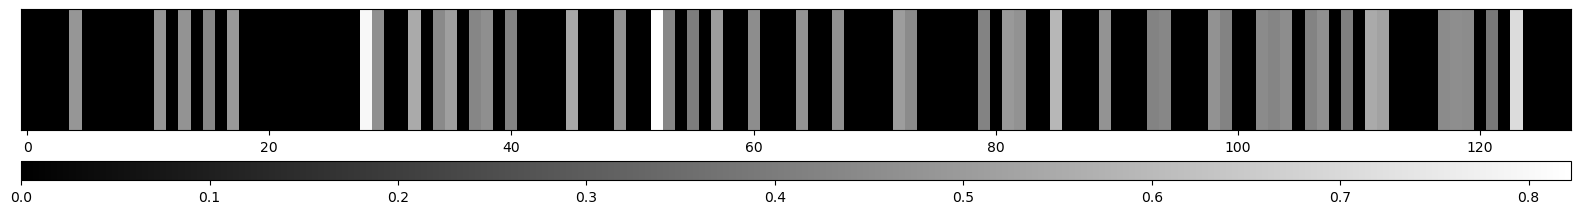

In [91]:
# Visualize the feature maps after the 1st dense
print("Visualize the 16 feature maps under the output layer 1st dense:")
i_layer = 9
f_max = list_feature_results[i_layer].max()
f_min = list_feature_results[i_layer].min()

print("The size of feature is:", list_feature_results[i_layer].shape)
print("The value of feature is:")
img_flatten = np.array([list_feature_results[i_layer][0] for i in range(10)])

fig,axes = plt.subplots(nrows = 1,ncols = 1, figsize= (20,20))
axes.get_yaxis().set_visible(False)
# axes.set_title(f"Flatten feature:")
photo = axes.imshow(img_flatten, cmap = 'gray',vmin = f_min,vmax = f_max, interpolation = "nearest")
fig.colorbar(photo, ax=axes, orientation='horizontal',aspect=80,pad=0.02)

Visualize the 2 feature maps under the output layer 2nd dense:
The size of feature is: (1, 2)
The value of feature is: [1.5623654127120972, -0.9399551749229431]
The value of feature is:


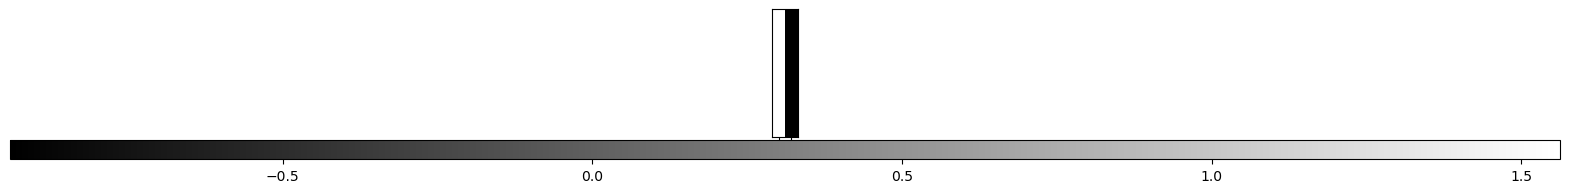

In [95]:
# Visualize the feature maps after the 2nd dense
print("Visualize the 2 feature maps under the output layer 2nd dense:")
i_layer = 10
f_max = list_feature_results[i_layer].max()
f_min = list_feature_results[i_layer].min()
print("The size of feature is:", list_feature_results[i_layer].shape)
print("The value of feature is:", list_feature_results[i_layer][0].tolist())
print("The value of feature is:")
img_flatten = np.array([list_feature_results[i_layer][0] for i in range(10)])

fig,axes = plt.subplots(nrows = 1,ncols = 1, figsize= (20,2))
axes.get_yaxis().set_visible(False)
# axes.set_title(f"Flatten feature:")
photo = axes.imshow(img_flatten, cmap = 'gray',vmin = f_min,vmax = f_max, interpolation = "nearest")
fig.colorbar(photo, ax=axes, orientation='horizontal',aspect=80,pad=0.02)

In [93]:
print("Visualize the 2 feature maps under the output layer 2nd dense and softmax:")
i_layer = 11
print("The size of feature is:", list_feature_results[i_layer].shape)
print("The value of feature is:", list_feature_results[i_layer][0].tolist())


Visualize the 2 feature maps under the output layer 2nd dense and softmax:
The size of feature is: (1, 2)
The value of feature is: [0.9243043065071106, 0.07569566369056702]
The value of feature is:


In [94]:
# Show the predict result on the input image
print("The prediction result on the input image:")
i_layer = 10
class_to_label = {0: "Sample OK", 1: " Sample NG"}
pred_class = np.argmax(list_feature_results[i_layer],axis=-1)[0]
truth_class = np.argmax(y_test,axis=-1)[img_test_index]
print("The predict class is:",pred_class)
print("The predict label is:", class_to_label[pred_class])
print("The ground truth label is:",class_to_label[truth_class])


The prediction result on the input image:
The predict class is: 0
The predict label is: Sample OK
The ground truth label is: Sample OK
